In [51]:
# Import libraries 
# Standard libraries for data processing 
import pandas as pd 
import numpy as np 
import re
import random 

# Data visualization
import seaborn as sns 
import matplotlib.pyplot as plt 
from PIL import Image 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 

# NLTK processing 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import PorterStemmer

# Modeling 
import torch as pt
import tensorflow as tf 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [52]:
# Load data sets 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [53]:
# How long is the data set?
print("Length of the data set: {}\n".format(len(train)))

# Select a random sample of the data set
train.sample(6)

Length of the data set: 7613



,id,keyword,location,text,target
1660,2397,collapsed,NaN,Look: #I have collapsed #after attempting to m...,0
735,1065,bleeding,"Gages Lake, IL",@beckyfeigin I defs will when it stops bleeding!,1
6797,9737,tragedy,NaN,#breakingnews Rly tragedy in MP: Some live to ...,1
204,289,ambulance,"Hannover, Germany",Twelve feared killed in Pakistani air ambulanc...,1
2683,3849,detonation,NaN,Ignition Knock (Detonation) Sensor Connector-C...,0
6874,9857,trauma,Colorado,What happens to us as sexual trauma #survivors...,0


In [54]:
# Print data types for objects.
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [55]:
#Object types should be converted to string types 
obj = ['keyword', 'location', 'text']

train[obj] = train[obj].astype(str)
test[obj] = test[obj].astype(str)

In [56]:
# How many items of each target are there?
train.groupby('target').id.count()

target
0    4342
1    3271
Name: id, dtype: int64

In [57]:
# Initiate stemmer and lemmatizer from nltk package
ps = PorterStemmer()

# Loop through data frame to lowercase keywords and stem them. 
for i in range(len(train)): 
    train.loc[i, 'keyword'] = str(re.sub('%20', ' ', train.loc[i, 'keyword'])) # For words separated by %20, replace with a blank space
    train.loc[i, 'keyword_stem'] = ps.stem(train.loc[i, 'keyword'])            # Stem words

In [58]:
# Function that takes in a data frame and target, returning a keyword pairs dictionary 
def kwDict(df, target): 
    kw = list(df[df['target']==target].keyword_stem)
    wordfreq = [kw.count(k) for k in kw]
    kw_dict = dict(list(zip(kw, wordfreq)))
    return kw_dict

In [59]:
# Generate keyword pairs for both disaster and non-disaster lists
kw1_dict = kwDict(train, 1)
kw0_dict = kwDict(train, 0)

In [60]:
# Print out first ten
print({k: kw1_dict[k] for k in list(kw1_dict)[:10]})
print({k: kw0_dict[k] for k in list(kw0_dict)[:10]})

{'nan': 42, 'ablaz': 13, 'accid': 24, 'airplane accid': 30, 'ambul': 20, 'annihil': 21, 'apocalyps': 9, 'armageddon': 5, 'armi': 5, 'arson': 22}
{'nan': 19, 'ablaz': 23, 'accid': 11, 'aftershock': 34, 'airplane accid': 5, 'ambul': 18, 'annihil': 42, 'apocalyps': 23, 'armageddon': 37, 'armi': 29}


In [61]:
# Create word clouds for both kw1 and kw0 dictionaries 
kw1_wc = WordCloud(background_color="black", width=2500, height=2500, relative_scaling=1.0).generate_from_frequencies(kw1_dict)
kw0_wc = WordCloud(background_color="black", width=2500, height=2500, relative_scaling=1.0).generate_from_frequencies(kw0_dict)

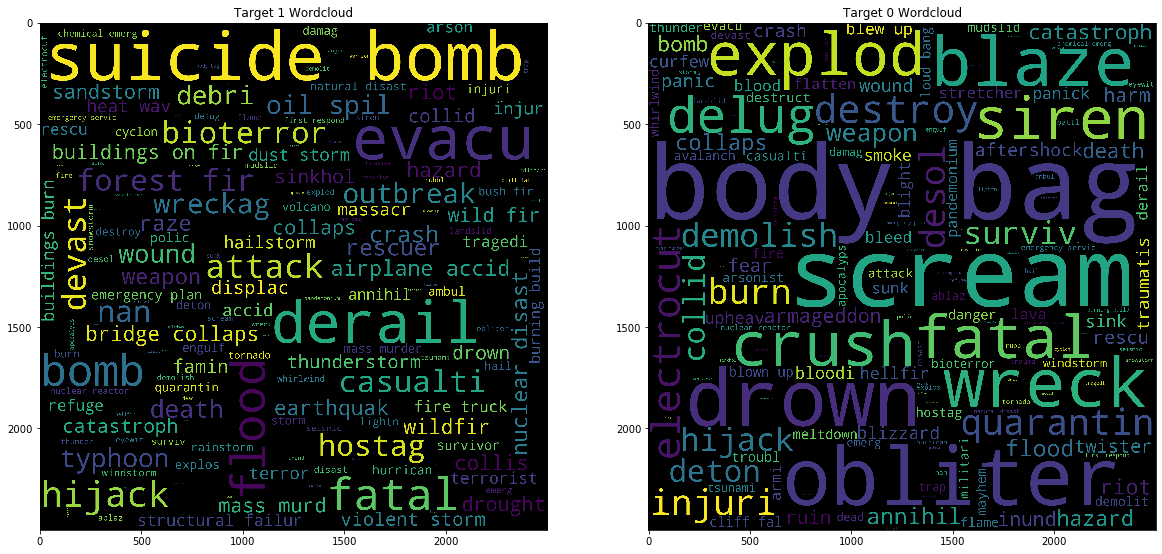

In [12]:
# Build word clouds for both targets
plt.figure(figsize=(20, 20))

# Wordcloud for Target = 1 
plt.subplot(121)
plt.imshow(kw1_wc)
plt.title('Target 1 Wordcloud')

# Wordcloud for Target = 0 
plt.subplot(122)
plt.imshow(kw0_wc)
plt.title('Target 0 Wordcloud')

plt.show()

In [62]:
# Define function to stem text
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(ps.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [63]:
# Create function that cleans text 
def cleanText(df, Series): 
    # Removes whitespace characters and converts words to lower case 
    df[Series] = df[Series].map(lambda x: re.sub(r'\W', ' ', x).lower())
    
    # Set stopwords 
    stop_words = stopwords.words('english')
    
    # Tokenize text 
    df['word_tokens'] = df.apply(lambda row: word_tokenize(row[Series]), axis=1)

    # Remove stopwords to filter out noise and reconnect strings into sentences. 
    df['clean_text'] = df['word_tokens'].apply(lambda x: [word for word in x if word not in stop_words])
    df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(str(word) for word in x))

    # Stem cleaned text using stemSentence function 
    df['stemmed'] = df['clean_text'].map(lambda x: stemSentence(x))
    
    return df

In [64]:
train = cleanText(train, 'text')

In [70]:
# Label encoder 
le = LabelEncoder()
kw = le.fit(train['keyword_stem'])
train['kws_le'] = kw.transform(train['keyword_stem'])

In [66]:
# Count Vectorizer for data modeling 
cv = CountVectorizer(min_df=5, binary=True, encoding='utf-8', ngram_range=(1,2), stop_words='english')

In [18]:
# Select model features, target, and train_test_split
features = train[['stemmed', 'kws_le']]
target = train['target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [19]:
cvec = cv.fit(X_train['stemmed'])
df_train = pd.DataFrame(cvec.transform(X_train['stemmed']).todense(), columns=cvec.get_feature_names())
df_test = pd.DataFrame(cvec.transform(X_test['stemmed']).todense(), columns=cvec.get_feature_names())

In [20]:
X_train = pd.concat([df_train, X_train['kws_le'].reset_index()], axis=1)
X_test = pd.concat([df_test, X_test['kws_le'].reset_index()], axis=1)

In [21]:
# Model with hyperparameters for tuning 
iterations = range(5000, 15001, 1000)
c_space = np.arange(0.1, 1.0, 0.1)

param_grid = {'max_iter':iterations, 
             'C':c_space}

svc = LinearSVC(random_state=42)

svc_cv = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1, verbose=0)

In [22]:
# Run model
svc_cv.fit(X_train, y_train)

# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(svc_cv.best_params_))  
print("Best score is {}".format(round(100 * svc_cv.best_score_, 2))) 

Tuned Logistic Regression Parameters: {'C': 0.9, 'max_iter': 11000}
Best score is 63.65


C:\Users\malon\.conda\envs\nlpdisaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
# Run model with best hyperparametres; print confusion matrix. 
y_pred = svc_cv.predict(X_test)
print('F1-score: {}\n'.format(round(100 * f1_score(y_test, y_pred), 3)))
print('Confusion matrix:\n {}'.format(confusion_matrix(y_test, y_pred)))

F1-score: 63.786

Confusion matrix:
 [[550 768]
 [154 812]]


In [24]:
# Next steps:
# 1. Tfidf > build model with these to compare results with keywords and locations only.
# 2. SIA for text
# 3. Test pytorch and tensorflow NN. 

# Bonus: 
# 1. Clean locations
# 2. Tie locations to keywords

In [71]:
for i in range(len(test)): 
    test.loc[i, 'keyword'] = str(re.sub('%20', ' ', test.loc[i, 'keyword'])) # For words separated by %20, replace with a blank space
    test.loc[i, 'keyword_stem'] = ps.stem(test.loc[i, 'keyword'])            # Stem words
    
test['kws_le'] = kw.transform(test['keyword_stem'])

In [72]:
test = cleanText(test, 'text')

In [73]:
df_test = pd.DataFrame(cvec.transform(test['stemmed']).todense(), columns=cvec.get_feature_names())
df_test = pd.concat([df_test, test['kws_le'].reset_index()], axis=1)

,00,00 pm,01,04,05,06,07,07 2015,08,08 05,...,ûª http,ûªt,ûªve,ûï,ûïwhen,ûïwhen saw,ûò,ûó,index,kws_le
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,105
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,105
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,105
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,105
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,105


In [75]:
test_pred = svc_cv.predict(df_test)

In [79]:
version = 1
name = 'results_v'+str(version)+'.csv'

results = pd.concat([test['id'], pd.DataFrame(test_pred)], axis=1)
results.rename(columns={0:'target'}, inplace=True)
results.to_csv(name, index=False)

version += 1